# Train in GPU


1. check gpu availability
   ```python
   import torch
   print(torch.cuda.is_available())
   device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   print("Using",device)

   #mac
   device = torch.device("mps"if torch.backends.mps.is_available() else torch.device("cpu"))
   print("Using",device)
   ```

print(device)
   ```
2. move model to gpu
   ```python
   model=YourModelClass()
   model=model.to(device)
   ```
3. move data to gpu inside training loop
   ```python
   for batch_features, batch_labels in train_loader:
       batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
   ```
4. modify evaluation loop similarly
   ```python
   with torch.no_grad():
       for batch_features, batch_labels in test_loader:
           batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
   ```

5. use large batch size if memory allows
    ```python
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    ```
6. enable dataloader pin_memory for faster data transfer
    ```python
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)
    ``` 


---


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

----

In [13]:
import torch
device = torch.device("mps"if torch.backends.mps.is_available() else torch.device("cpu"))
print("Using",device)

Using mps


In [3]:
df = pd.read_csv("../../datasets/fashion-mnist_train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df["label"].value_counts().sort_index()

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

In [7]:
torch.manual_seed(42)

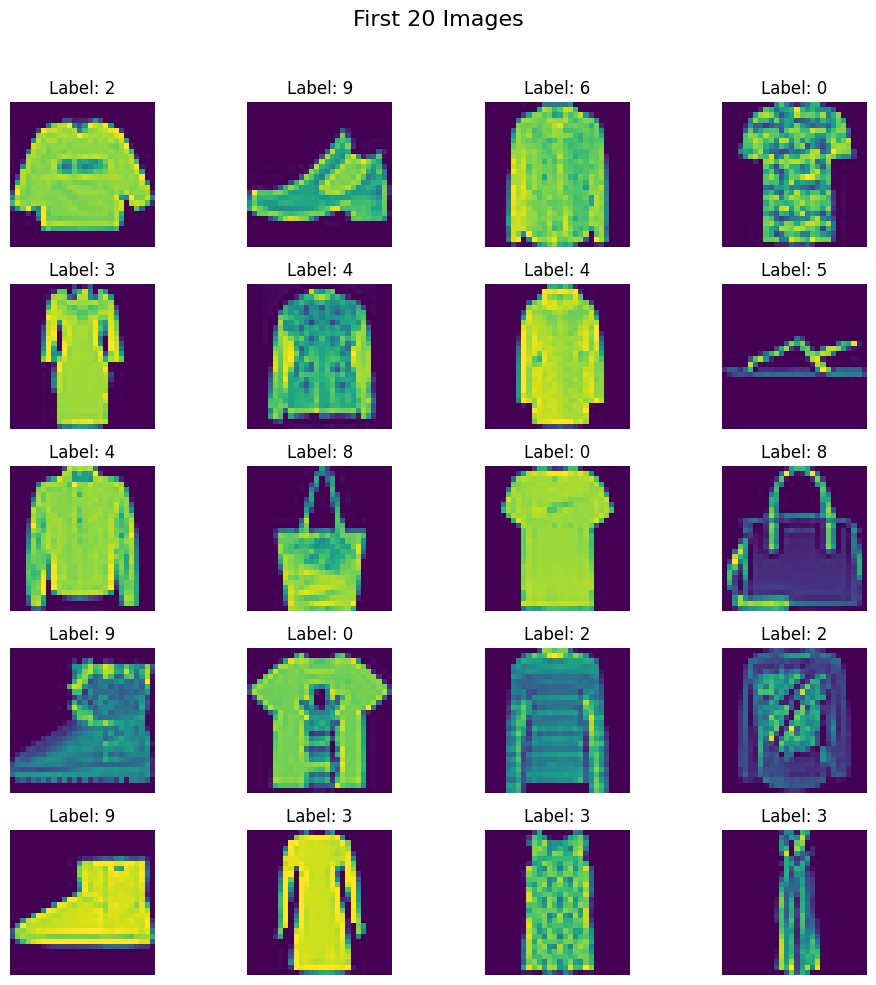

In [8]:
# Create a 5x4 grid of images
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
fig.suptitle("First 20 Images", fontsize=16)

# Plot the first 20 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis("off")  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [9]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
# scaling the feautures
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]], shape=(48000, 784))

In [14]:
X_train.shape

(48000, 784)

In [15]:
from numpy import float32

# create a customDataset class


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [16]:
X_train[0].shape

(784,)

In [17]:
X_train[0][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [18]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [19]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [20]:
# create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

------

In [22]:
# create train and test loader


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory=True)

In [23]:
# define nn class


class MySimpleNN(nn.Module):

    def __init__(self, num_features):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

In [24]:
# set learning rate and epochs
epochs = 100
learning_rate = 0.1

In [25]:
model = MySimpleNN(X_train.shape[1])
model=model.to(device)
# loss fn
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
len(train_loader)

1500

In [27]:
train_loader

--------

In [28]:
# training loop

for epoch in range(epochs):

    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        
        # forward pass
        outputs = model(batch_features)

        # calculate loss
        loss = criterion(outputs, batch_labels)

        # back pass
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch: {epoch + 1} , Loss: {avg_loss}")

/Users/rabinpoudel/Downloads/anaconda3/envs/air_ds_projects/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 , Loss: 0.6352692385911941
Epoch: 2 , Loss: 0.43003414149582386
Epoch: 3 , Loss: 0.3858709690098961
Epoch: 4 , Loss: 0.3583725085010131
Epoch: 5 , Loss: 0.3376641030833125
Epoch: 6 , Loss: 0.3221902217591802
Epoch: 7 , Loss: 0.30756560811648764
Epoch: 8 , Loss: 0.29611334375540416
Epoch: 9 , Loss: 0.2855041981637478
Epoch: 10 , Loss: 0.2726636084591349
Epoch: 11 , Loss: 0.26835035102814436
Epoch: 12 , Loss: 0.25898618865509826
Epoch: 13 , Loss: 0.2508434251323342
Epoch: 14 , Loss: 0.24267052692857882
Epoch: 15 , Loss: 0.23728725463648637
Epoch: 16 , Loss: 0.2319722787750264
Epoch: 17 , Loss: 0.22456941674277187
Epoch: 18 , Loss: 0.21967852419738967
Epoch: 19 , Loss: 0.2138062867851307
Epoch: 20 , Loss: 0.2113377228093644
Epoch: 21 , Loss: 0.20560202448566756
Epoch: 22 , Loss: 0.19955229680861036
Epoch: 23 , Loss: 0.19582781234383584
Epoch: 24 , Loss: 0.19087340498281022
Epoch: 25 , Loss: 0.18813317300503452
Epoch: 26 , Loss: 0.18244366780109703
Epoch: 27 , Loss: 0.180422546105

In [29]:
# set model to eval mode
model.eval()

MySimpleNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# evaluation code on train 
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in train_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct / total)

0.98075


In [ ]:
# evaluation code on test
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct / total)

0.8860833333333333
